In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt

# EXCLUSION
Select which stock should invest
- Dynamic Filtering
- Rolling window


In [ ]:
# 1. Cấu hình thời gian
start_date = "2024-01-01"

# Quan trọng: Để lấy dữ liệu HẾT ngày 30/09, parameter 'end' phải là ngày hôm sau (01/10)
# Tuy nhiên, để xem kết quả trade ngày 01/10 (nhằm đối chiếu), ta lấy luôn đến 02/10.
data_end_date = "2025-10-02"

# Ngày chúng ta đứng để phân tích (Analysis Date)
analysis_date = "2025-09-30"
# Ngày chúng ta sẽ vào lệnh (Trade Date)
trade_date = "2025-10-01"

tickers = ['AAPL', 'NVDA', 'MSFT', 'F', 'GME', 'AMC', 'BB']

print(f"--- Đang tải dữ liệu từ {start_date} đến {data_end_date} ---")
data = yf.download(tickers, start=start_date, end=data_end_date, progress=False, auto_adjust=True)

# 2. Tính toán chỉ báo (Rolling Window)
# Tính Dollar Volume trung bình 63 phiên (1 quý)
daily_dollar_vol = data['Close'] * data['Volume']
rolling_liquidity = daily_dollar_vol.rolling(window=63).mean()

# 3. Cắt dữ liệu tại ngày 30/09/2025
# Giả sử hôm nay là tối 30/9, ta chỉ được phép nhìn dữ liệu đến dòng này.
try:
    # .loc[analysis_date] lấy giá trị chỉ báo tại thời điểm đóng cửa 30/9
    # Đây là dữ liệu input để quyết định cho sáng mai.
    features_at_cutoff = rolling_liquidity.loc[analysis_date]

    # Lấy giá đóng cửa ngày 30/9 để tham chiếu
    price_at_cutoff = data['Close'].loc[analysis_date]

except KeyError:
    print(f"Lỗi: Ngày {analysis_date} không phải ngày giao dịch (Cuối tuần/Lễ).")
    exit()

# 4. Ra quyết định (Filter Universe) cho sáng 01/10
print(f"\n--- QUYẾT ĐỊNH TRADING CHO NGÀY {trade_date} ---")
print(f"(Dựa trên dữ liệu chốt sổ ngày {analysis_date})")

# Giả sử quy tắc: Chỉ trade mã có Thanh khoản TB > 200 Triệu USD (loại bỏ các cổ phiếu vốn hóa nhỏ
# trung bình, penny cap
# Công thức threshold cho retail trader = size lệnh mỗi mã/ 1% (tỷ lệ giới hạn)
threshold = 200_000_000

# Lọc danh sách
selected_stocks = features_at_cutoff[features_at_cutoff > threshold].index.tolist()
rejected_stocks = features_at_cutoff[features_at_cutoff <= threshold].index.tolist()

print(f"\n DANH SÁCH MUA (Eligible Universe):")
for stock in selected_stocks:
    liq = features_at_cutoff[stock]
    last_price = price_at_cutoff[stock]
    print(f"  - {stock:<4}: Liq ${liq:,.0f} | Giá đóng cửa hôm qua: ${last_price:.2f}")

print(f"\n DANH SÁCH LOẠI (Low Liquidity):")
print(f"  {rejected_stocks}")

# 5. (Optional) Kiểm tra thực tế diễn biến ngày 01/10
# Đây là bước Backtest: Xem nếu mua sáng 01/10 thì cuối ngày thế nào
print(f"\n--- KẾT QUẢ THỰC TẾ NGÀY {trade_date} (BACKTEST) ---")
try:
    # Lấy dữ liệu ngày 01/10
    next_day_data = data['Close'].loc[trade_date]

    for stock in selected_stocks:
        price_t0 = price_at_cutoff[stock]      # Giá đóng 30/9 (Tham chiếu)
        price_t1 = next_day_data[stock]        # Giá đóng 1/10
        change = (price_t1 - price_t0) / price_t0

        print(f"  - {stock}: {price_t0:.2f} -> {price_t1:.2f} ({change:+.2%})")

except KeyError:
    print(f"Chưa có dữ liệu ngày {trade_date} (hoặc là ngày nghỉ).")

# WINSORISING
Using IQR rule

--- Đang tải dữ liệu AAPL đến hết ngày 2025-09-30 ---
Ngày dữ liệu cuối cùng nhận được: 2025-09-30

--- THÔNG SỐ KẸP BIÊN (WINSORIZING PARAMETERS) ---
1. Ngưỡng dưới (Floor): -3.87%
2. Ngưỡng trên (Cap):   4.21%

--- KẾT QUẢ XỬ LÝ ---
Đã phát hiện và xử lý: 64 outliers (trên tổng 1443 ngày)

Ví dụ 3 ngày Outlier gần nhất bị kẹp:
  - Ngày 2025-08-06: +5.09% -> Bị sửa thành +4.21%
  - Ngày 2025-08-08: +4.24% -> Bị sửa thành +4.21%
  - Ngày 2025-09-22: +4.31% -> Bị sửa thành +4.21%


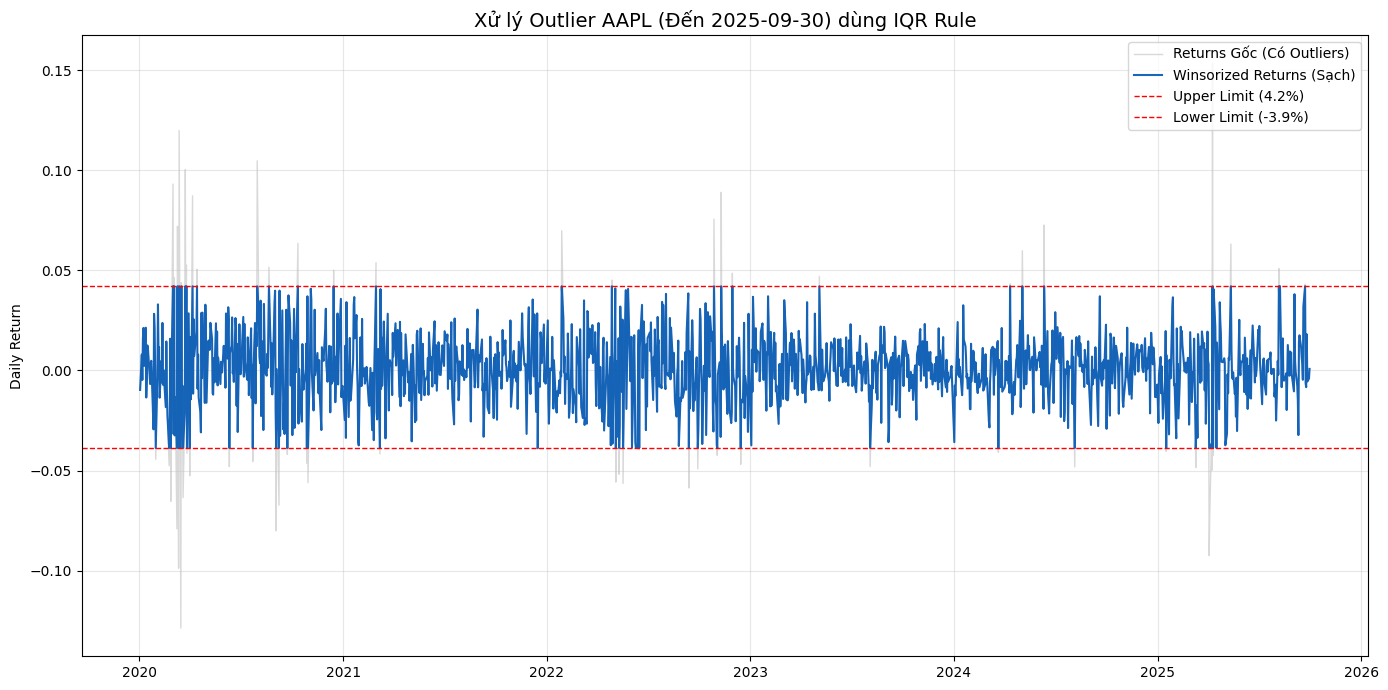

In [25]:
# --- 1. THIẾT LẬP THỜI GIAN  ---
ticker = "AAPL"
start_date = "2020-01-01"  # Lấy dữ liệu dài để tính thống kê ổn định

# Để lấy dữ liệu HẾT ngày 30/09/2025, tham số 'end' phải là ngày hôm sau
cutoff_date = "2025-09-30"
download_end_date = "2025-10-01"

print(f"--- Đang tải dữ liệu {ticker} đến hết ngày {cutoff_date} ---")
data = yf.download(ticker, start=start_date, end=download_end_date, progress=False, auto_adjust=True)

# Kiểm tra ngày cuối cùng trong dữ liệu
print(f"Ngày dữ liệu cuối cùng nhận được: {data.index[-1].date()}")

# --- 2. CHUẨN BỊ DỮ LIỆU (RETURNS) ---
# Chúng ta xử lý Outlier trên Lợi nhuận (Returns)
returns = data['Close'].pct_change().dropna().squeeze()

# --- 3. TÍNH NGƯỠNG OUTLIER (PHƯƠNG PHÁP IQR) ---

Q1 = returns.quantile(0.25)
Q3 = returns.quantile(0.75)
IQR = Q3 - Q1

# Xác định trần/sàn (Biên độ 1.5 lần IQR)
iqr_lower = Q1 - 1.5 * IQR
iqr_upper = Q3 + 1.5 * IQR

print(f"\n--- THÔNG SỐ KẸP BIÊN (WINSORIZING PARAMETERS) ---")
print(f"1. Ngưỡng dưới (Floor): {iqr_lower:.2%}")
print(f"2. Ngưỡng trên (Cap):   {iqr_upper:.2%}")

# --- 4. THỰC HIỆN WINSORIZING (KẸP BIÊN) ---
# Thay thế các giá trị vượt ngưỡng bằng giá trị ngưỡng
winsorized_returns = returns.clip(lower=iqr_lower, upper=iqr_upper)

# Đếm số lượng Outliers đã xử lý
outliers_indices = returns[(returns < iqr_lower) | (returns > iqr_upper)].index
num_outliers = len(outliers_indices)

print(f"\n--- KẾT QUẢ XỬ LÝ ---")
print(f"Đã phát hiện và xử lý: {num_outliers} outliers (trên tổng {len(returns)} ngày)")

# Hiển thị vài ví dụ cụ thể
if num_outliers > 0:
    print("\nVí dụ 3 ngày Outlier gần nhất bị kẹp:")
    example_dates = outliers_indices[-3:] # Lấy 3 ngày cuối
    for date in example_dates:
        original_val = returns.loc[date].item()
        # Xác định xem bị kẹp về trần hay sàn
        new_val = winsorized_returns.loc[date].item()
        print(f"  - Ngày {date.date()}: {original_val:+.2%} -> Bị sửa thành {new_val:+.2%}")

# --- 5. TRỰC QUAN HÓA (VISUALIZATION) ---
plt.figure(figsize=(14, 7))

# Vẽ dữ liệu gốc (Màu xám nhạt)
plt.plot(returns.index, returns, label='Returns Gốc (Có Outliers)', color='silver', alpha=0.6, linewidth=1)

# Vẽ dữ liệu đã xử lý (Màu xanh đậm)
plt.plot(winsorized_returns.index, winsorized_returns, label='Winsorized Returns (Sạch)', color='#0056b3', linewidth=1.5, alpha=0.9)

# Vẽ đường biên giới hạn
plt.axhline(y=iqr_upper, color='red', linestyle='--', linewidth=1, label=f'Upper Limit ({iqr_upper:.1%})')
plt.axhline(y=iqr_lower, color='red', linestyle='--', linewidth=1, label=f'Lower Limit ({iqr_lower:.1%})')

plt.title(f"Xử lý Outlier AAPL (Đến {cutoff_date}) dùng IQR Rule", fontsize=14)
plt.ylabel("Daily Return")
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [1]:
! git add .
! git commit -m "Update outliers"
! git push

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   ../LAB_2_3_SMA_MOMENTUM/MOMENTUM.ipynb
	modified:   ../LAB_5_TIME_SERIES_MODELING/Bollinger Bands.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


Everything up-to-date
